In [1]:
import QUANTAXIS as QA

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['KaiTi', 'SimHei', 'FangSong']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
mpl.rcParams['font.size'] = 14  # 字体大小
mpl.rcParams['axes.unicode_minus'] = False  # 正常显示负号

import numpy as np

import seaborn as sns

from base.JuUnits import excute_for_multidates
from base.Constants import trade_date_sse, LOW_FREQUENCE
from tools.QAAdapter import QA_adapter_get_blocks
import tools.QAAdapter as qaadapter
import tools.Sample_Tools as smpl

import pandas as pd

class Stock_Trend:
    """
        1.展示每个行业，平均以上的股票占比图
        2.获取变化趋势
    """
    def __init__(self, code_list = ['000001'], end='2021-04-30', gap=60, start=None, frequence=QA.FREQUENCE.DAY, MA=20):
        self.end = end
        self.gap = gap
        self.MA = MA
        if start is None:
            self.start = trade_date_sse[trade_date_sse.index(end)-self.gap]
        else:
            self.start = start
        self.blocks_view = code_list
        self.pivot = None
        self.frequence = frequence
        self.trend = None
                
    @property
    def hy_source(self):
        return self._hy_source
    
    @hy_source.setter
    def hy_source(self, value):
        if not value in ['tdxhy','sw_l1','sw_l2','sw_l3','gn']:
            raise TypeError('hy_source MUST BE [tdxhy|swhy|gn]')
        self._hy_source=value
        self.blocks_view = self.get_blocks_view()
        
    @property
    def is_low_frequence(self):
        return self.frequence in LOW_FREQUENCE

    
    def fit(self, blocks=None):
        if blocks is None or blocks == 'all':
            data = QA.QA_fetch_stock_day_adv(self.blocks_view, self.start, self.end)
            # data.data.index = data.data.index.map(lambda x: (x[0].tz_localize('UTC'), x[1]))
            # data.data.index.names = ['tz', 'code']
            cur_ret = smpl.get_current_return(data,'close').replace(np.nan, 0)
            ma_above = cur_ret * 100
        elif isinstance(blocks, list):
            ma_above = self.blocks_view[blocks].apply(self.check_MA_above)
        else:
            raise TypeError('fit(blocks) params error')

        self.pivot = ma_above.unstack().loc[:, self.blocks_view]
        print('pivot fit finish')
        
    def get_blocks_view(self):
        stock_list  = qaadapter.QA_adapter_get_code_from_block(self._hy_source, self.block_name)
        return stock_list

    def JCSC(self, ma=20):
        return self.pivot.apply(lambda x: QA.CROSS(x,QA.MA(x,ma))+QA.CROSS(QA.MA(x,ma),x)*-1, axis=0)
    
    def get_trend(self, window=3, absolute=False, plot=False):
        if absolute:
            self.trend = self.pivot.apply(lambda x: round((x-x.shift(window))/x.shift(window),2), axis=0)
            if plot: self.draw_plot(trend, cmap='coolwarm',vmin=-0.8, vmax=0.8)     
        else:
            # trend = self.pivot.rolling(3).apply(lambda y:round(np.polyfit(np.linspace(1,3,3),y,1)[0],2))
            # self.trend = trend.rolling(2).apply(lambda x:x[1]-x[0])

            trend = self.pivot
            self.trend = trend
            
        if plot:
            xlabel = self.blocks_view

            # stock_in_block_s = self.blocks_view.apply(lambda x:len(x))
        
            # ## modin的pivot会返回真正的切片，既没有多余的列，而pandas通过columns取到的是原始的数据表
            # if isinstance(self.pivot.columns[0],tuple):
            #     ## pandas
            #     xlabel = [columns[1]+'('+str(stock_in_block_s[columns[1]])+')' for columns in self.pivot.columns]
            # else:
            #     ## modin
            #     xlabel = [column+'('+str(stock_in_block_s[column])+')' for column in self.pivot.columns]
            
            block_count = len(self.trend.columns)
            if block_count > 50:
                self.draw_plot(self.trend.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)], cmap='coolwarm',vmin=-1, vmax=1)
                self.draw_plot(self.trend.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count], cmap='coolwarm',vmin=-1, vmax=1)
            else:
                self.draw_plot(trend, cmap='coolwarm',vmin=-1, vmax=1)
        return self.trend
    
    def get_trend_rank(self, date_str=None):
        if self.trend is None:
            self.get_trend()
        if date_str is None:
            return self.trend.iloc[-1].rank(ascending=False,method='first').sort_values()
        if not isinstance(date_str, str):
            raise TypeError('date_str MUST BE str')
        return self.trend.loc[date_str].rank(ascending=False,method='first').sort_values()
    
    def plot(self):

        xlabel = self.blocks_view

        block_count = len(self.pivot.columns)
        
        if block_count > 100:
            # 如果板块过多，分成两张表
            # 非modin可以不处理xlabel
            self.draw_plot(self.pivot.iloc[:,0:int(block_count/2)], xlabel[0:int(block_count/2)])
            self.draw_plot(self.pivot.iloc[:,int(block_count/2):block_count], xlabel[int(block_count/2):block_count])
        else:
            self.draw_plot(self.pivot, xlabel)
    
    def draw_plot(self,data,xlabel=None,cbar=True,cmap='coolwarm',vmin=None, vmax=None):
        width = 40*len(data.columns)
        high = 15*len(data.index)
        if width > 2100:width = 2100
        if high < 520:high = 520
        
        formater = '%Y%m%d' if self.is_low_frequence else '%Y%m%d %H%M%S'
        ylabel = [pd.to_datetime(x).strftime(formater) for x in self.pivot.index.values]
        
        fig = plt.figure(figsize=(width/48,high/72))
        if xlabel is None:
            sns.heatmap(data,fmt='.1f', yticklabels=ylabel,
                         linewidths=0.5, annot = True, cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            sns.heatmap(data,fmt='.1f', yticklabels=ylabel, xticklabels=xlabel, 
                         linewidths=0.5, annot = True, cbar=cbar,cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(rotation = -90)
        plt.show()


jqdatasdk not installed
you are using non-interactive mdoel quantaxis


In [4]:
from QUANTAXIS.QAAnalysis.QAAnalysis_finance import QAAnalysis_finance
from QUANTAXIS.QASetting.QALocalize import analysis_path
import tools.QAAdapter as qaadapter
import os


# block_name = '通信设备'
# block_name = '旅游景点'
# block_name = '影视音像'
# block_name = '电器仪表'
# block_name = '软件服务'
# block_name = '通信设备'
# block_name = '旅游景点'
# block_name = '影视音像'
# block_name = '电器仪表'
# block_name = '软件服务'
# block_name = '油服工程'
# block_name = '家电零部件Ⅱ'
# block_name = '化学纤维'
# block_name = '游戏Ⅱ'
# block_name = '中药Ⅱ'
# block_name = '股份制银行Ⅱ'
# block_name = '证券Ⅱ'
# block_name = '航空装备Ⅱ'
# block_name = '国有大型银行Ⅱ'
# block_name = '医疗器械'
block_name = '白酒Ⅱ'
# block_name = '煤炭开采'
# block_name = '证券Ⅱ'
# block_name = '计算机设备'
# block_name = '消费电子'
hy = 'sw_l2'


code_list  = qaadapter.QA_adapter_get_code_from_block(hy, block_name)
# code_list  = qaadapter.QA_adapter_get_code_from_block('tdxhy', '软件服务')

print(smpl.get_stock_name(code_list), len(code_list))

# code_list = ['000408']
print("code list len ", len(code_list))
factors = ['roe', 'roa', 'profit_revenue', 'revenue_incr_rate', 'cash_incr_rate']
start = '2020-12-31'
end = '2023-03-31'
qaanalysis_finance = QAAnalysis_finance(code_list, factors,  start, end)
finance_factors = qaanalysis_finance.finance_factors_all_stock()
print(finance_factors)

csv_file = os.path.join(analysis_path, block_name + start + '_' + end + 'temp_finance_factors.csv')
finance_factors.to_csv(csv_file)

finance_rank = qaanalysis_finance.finance_factors_rank(finance_factors)

if finance_rank.empty:
  print("finance factors are None")
else:
  csv_file = os.path.join(analysis_path, block_name + start + '_' + end + '_finance.csv')
  print('finance_rank write to ', csv_file)
  finance_rank.to_csv(csv_file, index=True)

print(finance_rank)
hy = 'sw_l2'


code_list  = qaadapter.QA_adapter_get_code_from_block(hy, block_name)
# code_list  = qaadapter.QA_adapter_get_code_from_block('tdxhy', '软件服务')

print(smpl.get_stock_name(code_list), len(code_list))

# code_list = ['000408']
print("code list len ", len(code_list))
factors = ['roe', 'roa', 'profit_revenue', 'revenue_incr_rate', 'cash_incr_rate']
start = '2020-12-31'
end = '2023-03-31'
qaanalysis_finance = QAAnalysis_finance(code_list, factors,  start, end)
finance_factors = qaanalysis_finance.finance_factors_all_stock()
print(finance_factors)

csv_file = os.path.join(analysis_path, block_name + start + '_' + end + 'temp_finance_factors.csv')
finance_factors.to_csv(csv_file)

finance_rank = qaanalysis_finance.finance_factors_rank(finance_factors)

if finance_rank.empty:
  print("finance factors are None")
else:
  csv_file = os.path.join(analysis_path, block_name + start + '_' + end + '_finance.csv')
  print('finance_rank write to ', csv_file)
  finance_rank.to_csv(csv_file, index=True)

print(finance_rank)

code
000568     泸州老窖
000596     古井贡酒
000799      酒鬼酒
000858    五 粮 液
000860     顺鑫农业
000995     皇台酒业
002304     洋河股份
002646     天佑德酒
600197      伊力特
600199     金种子酒
600519     贵州茅台
600559     老白干酒
600696     岩石股份
600702     舍得酒业
600779      水井坊
600809     山西汾酒
603198     迎驾贡酒
603369      今世缘
603589      口子窖
603919      金徽酒
Name: name, dtype: object 20
code list len  20
                           roe        roa  profit_revenue  revenue_incr_rate  \
report_date code                                                               
2020-12-31  '000568  26.027000  17.019852       35.780741         368.768665   
2021-03-31  '000568   8.588000   5.874340       43.564923         -34.459472   
2021-06-30  '000568  17.386999  11.375172       45.788442         -19.673117   
2021-09-30  '000568  23.816000  16.832577       44.573883         -15.270831   
2021-12-31  '000568  28.372000  18.368284       38.451517         312.541568   
...                        ...        ...             ...           

pivot fit finish


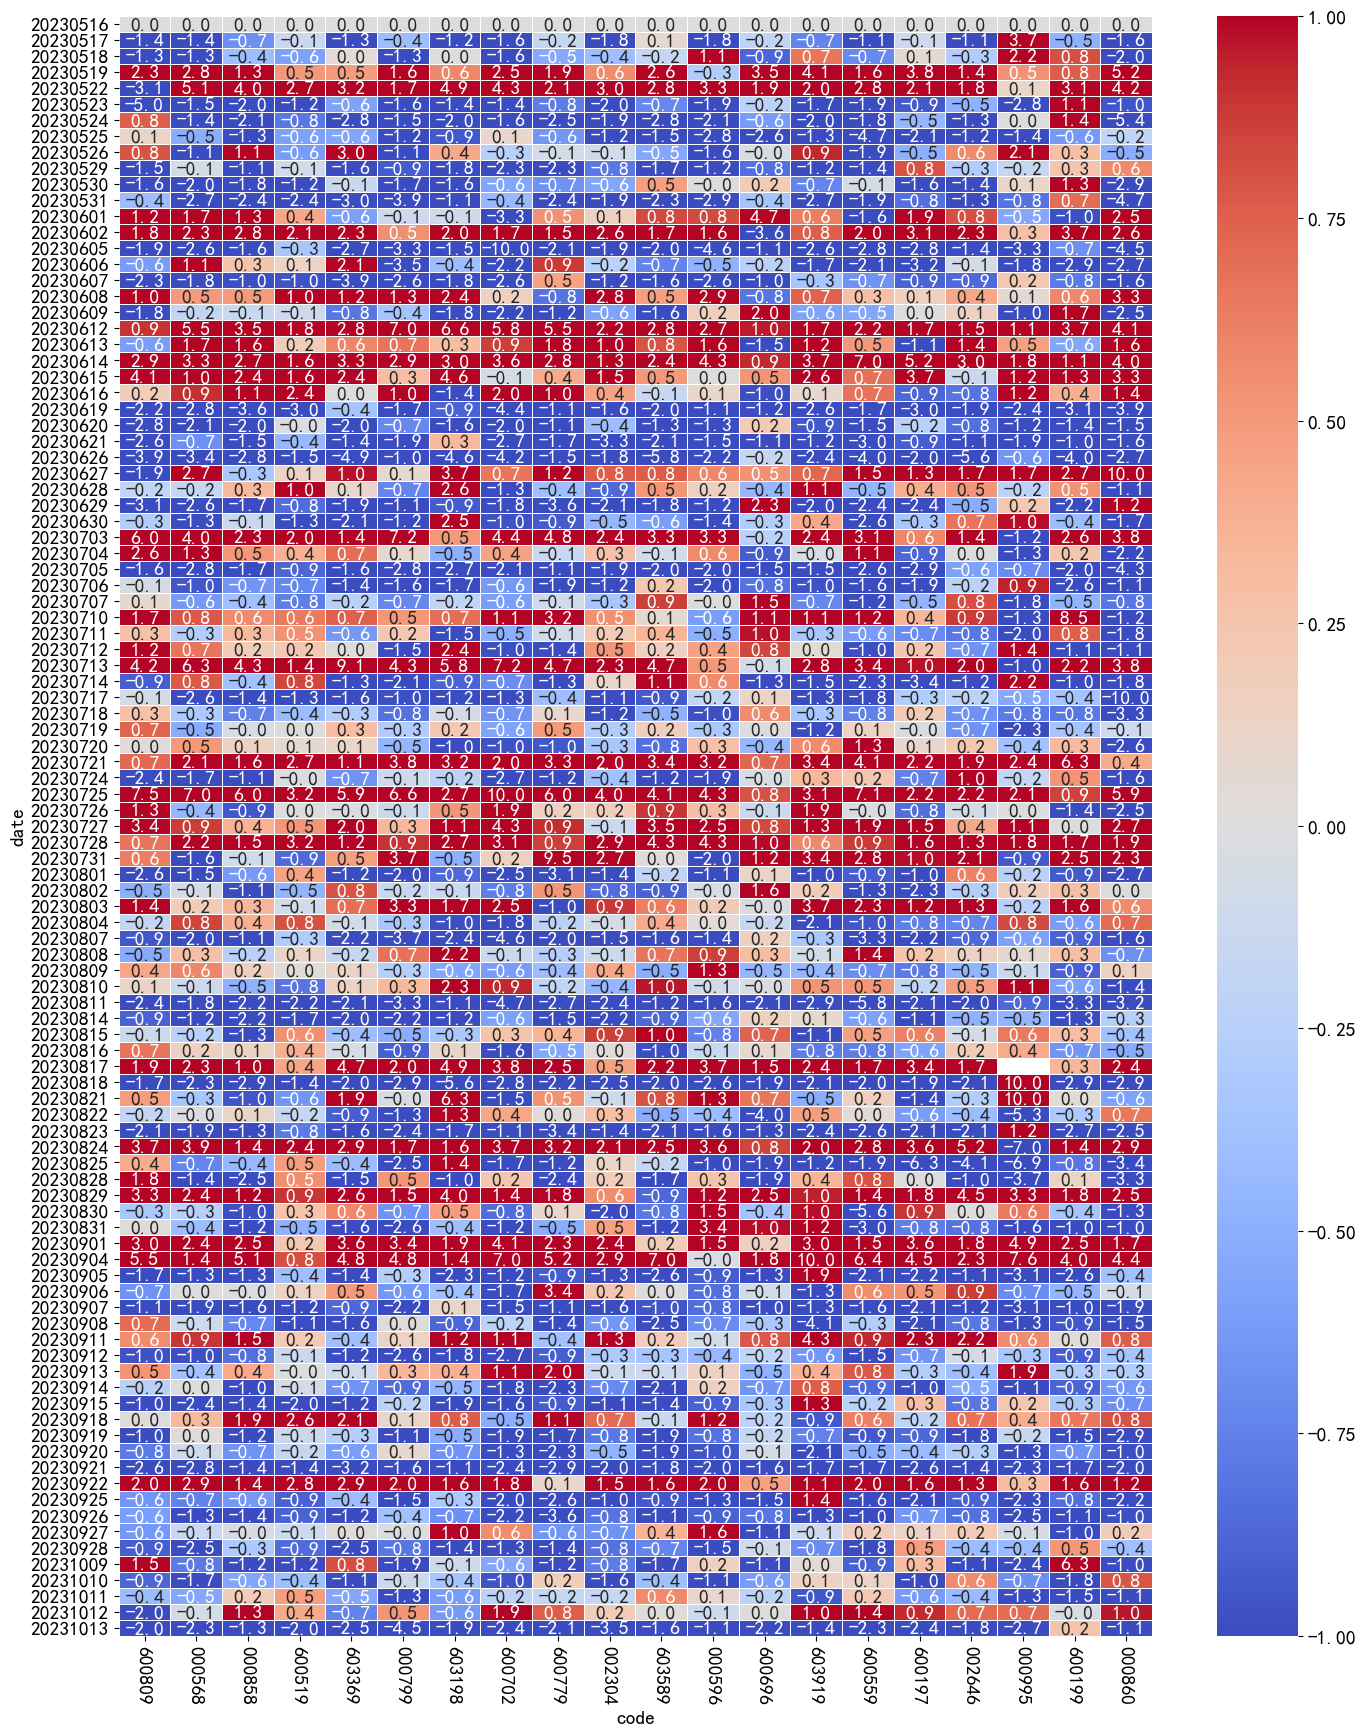

code,600809,000568,000858,600519,603369,000799,603198,600702,600779,002304,603589,000596,600696,603919,600559,600197,002646,000995,600199,000860
date,,,,,,,,,,,,,,,,,,,,
2023-05-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-05-17,-1.413276,-1.408451,-0.674526,-0.134446,-1.334489,-0.408745,-1.219925,-1.565858,-0.161290,-1.786951,0.071035,-1.801866,-0.199045,-0.736799,-1.065956,-0.109569,-1.061571,3.741497,-0.491291,-1.605709
2023-05-18,-1.329279,-1.252381,-0.401559,-0.587889,0.035131,-1.307626,0.000000,-1.634435,-0.533118,-0.401975,-0.159716,1.124986,-0.877543,0.659794,-0.707071,0.073126,-0.286123,2.240437,0.807899,-1.994560
2023-05-19,2.262922,2.787288,1.268825,0.502661,0.491659,1.615087,0.583190,2.536783,1.867793,0.566452,2.559545,-0.277218,3.501006,4.055715,1.593761,3.799781,1.434720,0.534474,0.756901,5.211224
2023-05-22,-3.138454,5.090312,3.987119,2.736099,3.180150,1.694109,4.911323,4.267689,2.136480,2.999366,2.755633,3.256435,1.905132,2.047244,2.770360,2.076734,1.838755,0.106326,3.137428,4.161782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,1.478079,-0.784676,-1.172325,-1.198187,0.818135,-1.938556,-0.122366,-0.552000,-1.243369,-0.780526,-1.739130,0.158205,-1.127005,0.035236,-0.905172,0.303556,-1.120448,-2.437538,6.292517,-1.037165
2023-10-10,-0.880513,-1.702722,-0.557464,-0.393922,-1.149620,-0.127168,-0.353934,-0.965329,0.184657,-1.635641,-0.393314,-1.061602,-0.613766,0.140895,0.130492,-0.994380,0.566572,-0.687071,-1.760000,0.786026
2023-10-11,-0.415110,-0.549008,0.189036,0.480226,-0.547289,-1.284871,-0.614754,-0.211193,-0.167560,-0.166284,0.572557,0.100245,-0.220556,-0.949701,0.217202,-0.611354,-0.422535,-1.257862,-1.547231,-1.126516


In [5]:
stock_trend = Stock_Trend(code_list = list(finance_rank.index.str[1:].values), end='2023-10-13', gap=100, frequence=QA.FREQUENCE.DAY, MA = 5)
stock_trend.fit()
stock_trend.get_trend(plot=True)